In [1]:
%load_ext autoreload
%autoreload 2

from functions.chase import *

Using TensorFlow backend.


In [2]:
setup_gpus()

GPUs found: 0


In [3]:
ds_all, ds_all_centered, datasets, datasets_centered, ds_counts = load_data()

loading: betternot_and_retrograde
	 Shape: (9925, 53, 3)
	 Min: [-1.96127391 -4.00212193 -0.15710293]
	 Max: [2.1591475  3.52660036 2.09531498]
loading: beyond
	 Shape: (5803, 53, 3)
	 Min: [-2.18821788 -2.68805718 -0.06788409]
	 Max: [2.1671412  3.16986203 2.16449094]
loading: chunli
	 Shape: (3866, 53, 3)
	 Min: [-1.50739741 -2.62433457 -0.08408955]
	 Max: [1.38144195 1.92739224 2.07176852]
loading: honey
	 Shape: (5309, 53, 3)
	 Min: [-2.40029621 -4.7584796  -0.12750754]
	 Max: [0.95588988 3.2632885  2.06287146]
loading: knownbetter
	 Shape: (6649, 53, 3)
	 Min: [-2.42928696 -3.50348401 -0.48134506]
	 Max: [2.13536358 3.36868167 2.0231936 ]
loading: penelope
	 Shape: (6757, 53, 3)
	 Min: [-2.37398148 -3.10730028 -0.15576062]
	 Max: [1.6543231  3.20413566 2.22775602]
Full data shape: (38309, 53, 3)


In [4]:
# Cool frame numbers: 
# 11910
# 9259
# 21755
# 2207

In [5]:
seq_len = 128
# index_start = 21755
index_start = np.random.randint(0,len(ds_all_centered)-seq_len)
print("Seeding with frame {}".format(index_start))
xtest = ds_all[index_start:index_start+seq_len]
HTML(animate_stick(xtest))

Seeding with frame 33660


In [161]:
seq_len = 128
index_start = len(ds_all_centered)-seq_len
# index_start = np.random.randint(0,len(ds_all_centered)-seq_len)
print("Seeding with frame {}".format(index_start))
xtest = ds_all[index_start:index_start+seq_len]
HTML(animate_stick(xtest, figsize=(16,12), cmap='inferno'))

Seeding with frame 38181


In [6]:
seq_len      = 128
latent_dim   = 256
n_layers     = 3 #2
n_units      = 384 #256
use_dense    = True
kl_weight    = 1 #1e-2
resolution   = 3e-1 #1e-2
lr           = 3e-4
do_rotations = True
extrap_len   = seq_len//2
#do_shift     = False
#do_inplace   = False

encoder, decoder, auto, mk_continuizer = mk_seq_ae(ds_all, seq_len=seq_len, latent_dim=latent_dim,
                                   n_units=n_units, n_layers=n_layers,
                                  use_dense=use_dense, kl_weight=kl_weight,
                                  resolution=resolution, do_rotations=do_rotations, extrap_len=extrap_len)
continuizer = mk_continuizer(1)
encoder.summary()
decoder.summary()
auto.summary()

K.set_value(auto.optimizer.lr, lr)

loss_history = []

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 53, 3)   0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 128, 159)     0           input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128, 384)     835584      reshape_1[0][0]                  
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 128, 384)     1181184     lstm_1[0][0]                     
_____________________________________

In [ ]:
# Save the model architecture
with open('vae_lstm_enc_model.json', 'w') as f:
    f.write(encoder.to_json())
with open('vae_lstm_dec_model.json', 'w') as f:
    f.write(decoder.to_json())
with open('vae_lstm_auto_model.json', 'w') as f:
    f.write(auto.to_json())

# Train:

In [ ]:
batch_size = 128 #32
epochs = 10
lr = 1e-5
kl_weight = 2e-4  # range from 1e-5 to 1e-2
nstep = sum([c-seq_len for c in ds_counts])//batch_size

K.set_value(auto.optimizer.lr, lr) 
K.set_value(auto.hp_kl_weight, kl_weight)

try:
    auto.fit_generator(gen_batches_safe(ds_all_centered, ds_counts, batch_size, seq_len),steps_per_epoch=nstep, epochs=epochs, verbose=1)
    
except KeyboardInterrupt:
    print("Interrupted.")

print("Updating loss history")
loss_history.extend(auto.history.history['loss'])

In [ ]:
nskip = 0
xepochs = np.arange(len(loss_history))+1
plt.plot(xepochs[nskip:], loss_history[nskip:])

In [ ]:
# Save weights:
encoder.save_weights('learning_rate_'+lr+'vae_lstm_enc_weights.h5')
decoder.save_weights('learning_rate_'+lr+'vae_lstm_dec_weights.h5')
auto.save_weights('learning_rate_'+lr+'vae_lstm_auto_weights.h5')

# Save model: 
encoder.save('learning_rate_'+lr+'vae_lstm_enc_model.h5')
decoder.save('learning_rate_'+lr+'vae_lstm_dec_model.h5')
auto.save('learning_rate_'+lr+'vae_lstm_auto_model.h5')

## Check autoencoder reconstruction performance

In [7]:
encoder.load_weights('weights/checkpoint_weights_vae_lstm_continued2_lr_0.001_encoder.h5')
decoder.load_weights('weights/checkpoint_weights_vae_lstm_continued2_lr_0.001_decoder.h5')
auto.load_weights('weights/checkpoint_weights_vae_lstm_continued2_lr_0.001_autoencoder.h5')
auto.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 53, 3)        0         
_________________________________________________________________
rotation_layer_1 (RotationLa (None, 128, 53, 3)        0         
_________________________________________________________________
model_1 (Model)              [(None, 256), (None, 256) 3395072   
_________________________________________________________________
model_2 (Model)              (None, 128, 53, 3)        2807040   
_________________________________________________________________
rotation_layer_2 (RotationLa (None, 128, 53, 3)        0         
Total params: 6,202,112
Trainable params: 6,202,112
Non-trainable params: 0
_________________________________________________________________


The autoencoder (red) tries to imitate the real Mariel (pink):

In [8]:
index_start = np.random.randint(0,len(ds_all_centered)-seq_len)
index_start = 2207
print("Seeding with frame {}".format(index_start))
xtest = ds_all_centered[index_start:index_start+seq_len]
xpred = auto.predict(np.expand_dims(xtest,axis=0))[0]
HTML(animate_stick(xtest,ghost=xpred, dot_alpha=0.7, ghost_shift=0.2))

Seeding with frame 2207


# Random 2D slice of the 256-dimensional latent space:

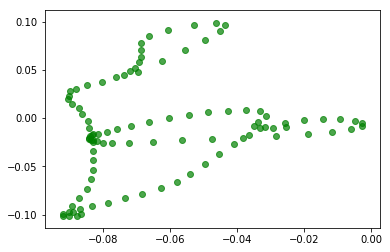

In [9]:
i = 0
z_points = []
indices = []
index_start = 0
while(i<100):
#     index_start = np.random.randint(0,len(ds_all_centered)-seq_len)  # random sequences each time
    index_start = index_start+1
    indices.append(index_start)
    xtest = ds_all_centered[index_start:index_start+seq_len]
    _, ztest, _ = encoder.predict(np.expand_dims(xtest,axis=0))
    z_points.append(ztest)
    i += 1
# print(len(indices))
# print(len(z_points))
index1 = np.random.randint(0,256)
index2 = np.random.randint(0,256)

for i in range(len(z_points)):
    plt.scatter(z_points[i][0,index1],z_points[i][0,index2],c='green',alpha='0.7')
#     print(z_points[i][0,index1],z_points[i][0,index2])

## Try some variations by adding noise to latent space:

In [10]:
_, ztest, _ = encoder.predict(np.expand_dims(xtest,axis=0))
xproj = decoder.predict(ztest + np.random.normal(0,0.25,latent_dim))[0]
HTML(animate_stick(xtest, ghost=xproj, ghost_shift=0.2))

In [11]:
_, ztest, _ = encoder.predict(np.expand_dims(xtest,axis=0))
xproj = decoder.predict(ztest + np.random.normal(0,0.5,latent_dim))[0]
HTML(animate_stick(xtest, ghost=xproj, ghost_shift=0.2))

In [12]:
_, ztest, _ = encoder.predict(np.expand_dims(xtest,axis=0))
xproj = decoder.predict(ztest + np.random.normal(0,1,latent_dim))[0]
HTML(animate_stick(xtest, ghost=xproj, ghost_shift=0.2))

## Try sampling randomly from the latent space

In [52]:
sigma = 3
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
HTML(animate_stick(xgen, figsize=(16,12), cmap='inferno'))

In [16]:
# sigma = 1
# latent_point = np.random.normal(0,sigma,(1,latent_dim))
# print(latent_point.shape)
# print(latent_point)

# Progress smoothly through the real data; gradually increase sigma

In [33]:
# index_start = np.random.randint(0,len(ds_all_centered)-seq_len)
index_start = 2207
sigma = 5
print("Frames: {} - {}; Sigma = {}".format(index_start,index_start+seq_len,sigma))
xtest = ds_all_centered[index_start:index_start+seq_len]
_, ztest, _ = encoder.predict(np.expand_dims(xtest,axis=0))
xproj = decoder.predict(ztest + np.random.normal(0,sigma,latent_dim))[0]
HTML(animate_stick(xtest, ghost=xproj, ghost_shift=0.2, figsize=(16,12)))
# HTML(animate_stick(xtest, ghost=xproj, ghost_shift=0.2))

Frames: 2207 - 2335; Sigma = 5


In [24]:
index_start = index_start + seq_len
sigma = sigma - 1
print("Frames: {} - {}; Sigma = {}".format(index_start,index_start+seq_len,sigma))
xtest = ds_all_centered[index_start:index_start+seq_len]
_, ztest, _ = encoder.predict(np.expand_dims(xtest,axis=0))
xproj = decoder.predict(ztest + np.random.normal(0,sigma,latent_dim))[0]
HTML(animate_stick(xtest, ghost=xproj, ghost_shift=0.2))

Frames: 2335 - 2463; Sigma = 4


In [25]:
index_start = index_start + seq_len
sigma = sigma - 1
print("Frames: {} - {}; Sigma = {}".format(index_start,index_start+seq_len,sigma))
xtest = ds_all_centered[index_start:index_start+seq_len]
_, ztest, _ = encoder.predict(np.expand_dims(xtest,axis=0))
xproj = decoder.predict(ztest + np.random.normal(0,sigma,latent_dim))[0]
HTML(animate_stick(xtest, ghost=xproj, ghost_shift=0.2))

Frames: 2463 - 2591; Sigma = 3


In [26]:
index_start = index_start + seq_len
sigma = sigma - 1
print("Frames: {} - {}; Sigma = {}".format(index_start,index_start+seq_len,sigma))
xtest = ds_all_centered[index_start:index_start+seq_len]
_, ztest, _ = encoder.predict(np.expand_dims(xtest,axis=0))
xproj = decoder.predict(ztest + np.random.normal(0,sigma,latent_dim))[0]
HTML(animate_stick(xtest, ghost=xproj, ghost_shift=0.2))

Frames: 2591 - 2719; Sigma = 2


In [27]:
index_start = index_start + seq_len
sigma = sigma - 1
print("Frames: {} - {}; Sigma = {}".format(index_start,index_start+seq_len,sigma))
xtest = ds_all_centered[index_start:index_start+seq_len]
_, ztest, _ = encoder.predict(np.expand_dims(xtest,axis=0))
xproj = decoder.predict(ztest + np.random.normal(0,sigma,latent_dim))[0]
HTML(animate_stick(xtest, ghost=xproj, ghost_shift=0.2))

Frames: 2719 - 2847; Sigma = 1


In [28]:
index_start = index_start + seq_len
sigma = sigma - 1
print("Frames: {} - {}; Sigma = {}".format(index_start,index_start+seq_len,sigma))
xtest = ds_all_centered[index_start:index_start+seq_len]
_, ztest, _ = encoder.predict(np.expand_dims(xtest,axis=0))
xproj = decoder.predict(ztest + np.random.normal(0,sigma,latent_dim))[0]
HTML(animate_stick(xtest, ghost=xproj, ghost_shift=0.2))

Frames: 2847 - 2975; Sigma = 0


# Progressively larger samplings

In [53]:
sigma_increase = 0.1

In [54]:
sigma = 0
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
HTML(animate_stick(xgen, figsize=(16,12), cmap='inferno'))

In [55]:
sigma = sigma + sigma_increase
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
HTML(animate_stick(xgen, figsize=(16,12), cmap='inferno'))

In [56]:
sigma = sigma + sigma_increase
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
HTML(animate_stick(xgen, figsize=(16,12), cmap='inferno'))

In [57]:
sigma = sigma + sigma_increase
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
HTML(animate_stick(xgen, figsize=(16,12), cmap='inferno'))

In [58]:
sigma = sigma + sigma_increase
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
HTML(animate_stick(xgen, figsize=(16,12), cmap='inferno'))

In [59]:
sigma = sigma + sigma_increase
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
HTML(animate_stick(xgen, figsize=(16,12), cmap='inferno'))

In [60]:
sigma = sigma + sigma_increase
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
HTML(animate_stick(xgen, figsize=(16,12), cmap='inferno'))

In [61]:
sigma = sigma + sigma_increase
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
HTML(animate_stick(xgen, figsize=(16,12), cmap='inferno'))

In [62]:
sigma = sigma + sigma_increase
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
HTML(animate_stick(xgen, figsize=(16,12), cmap='inferno'))

In [63]:
sigma = sigma + sigma_increase
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
HTML(animate_stick(xgen, figsize=(16,12), cmap='inferno'))

In [113]:
sigma = sigma + sigma_increase
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
HTML(animate_stick(xgen, figsize=(16,12), cmap='inferno'))

In [ ]:
sigma = sigma + sigma_increase
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
HTML(animate_stick(xgen, figsize=(16,12), cmap='inferno'))

# Big sigma only

In [158]:
sigma = 5
xgen = decoder.predict(np.random.normal(0,sigma,(1,latent_dim)))[0]
HTML(animate_stick(xgen, figsize=(16,12), cmap='inferno'))